In [2]:
import pandas as pd
import string
import re
import nltk
import torch
from transformers import BertModel, BertTokenizer
import sklearn
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [4]:
# Get needed data

# Training data
data_sampled_extrovert = pd.read_csv('data/df_extrovert_introvert_joined_sampled.csv')
data_sampled_feeling = pd.read_csv('data/df_feeling_thinking_joined_sampled.csv')
data_sampled_judging = pd.read_csv('data/df_judging_perceiving_joined_sampled.csv')
data_sampled_sensing = pd.read_csv('data/df_sensing_intuitive_joined_sampled.csv')

# Test data
data_test = pd.read_csv('data/personality.csv')

In [10]:
data_test

,auhtor_ID,post_extrovert,extrovert,post_feeling,feeling,post_judging,judging,post_sensing,sensing
0,t2_12bhu7,I wear a Lorna shore shirt out alot in public ...,1.0,I wear a Lorna shore shirt out alot in public ...,1.0,I wear a Lorna shore shirt out alot in public ...,0.0,I wear a Lorna shore shirt out alot in public ...,0.0
1,t2_12jbpd,I'd say this is a very accurate characterizati...,1.0,I'd say this is a very accurate characterizati...,0.0,I'd say this is a very accurate characterizati...,0.0,I'd say this is a very accurate characterizati...,0.0
2,t2_12uwr5,Ya know like most people with home decorations...,0.0,Ya know like most people with home decorations...,0.0,Ya know like most people with home decorations...,1.0,Ya know like most people with home decorations...,0.0
3,t2_12zm15,It's true tho. They're kinda more interesting ...,0.0,It's true tho. They're kinda more interesting ...,1.0,It's true tho. They're kinda more interesting ...,0.0,It's true tho. They're kinda more interesting ...,0.0
4,t2_13cjjl,"Yeah, but that's one of the things that make m...",0.0,"Yeah, but that's one of the things that make m...",0.0,"Yeah, but that's one of the things that make m...",0.0,"Yeah, but that's one of the things that make m...",1.0
...,...,...,...,...,...,...,...,...,...
150,t2_vfp8y,so change profession then. this would be inadm...,0.0,so change profession then. this would be inadm...,0.0,so change profession then. this would be inadm...,1.0,so change profession then. this would be inadm...,0.0
151,t2_w0842,The technological singularity. And the possibi...,0.0,The technological singularity. And the possibi...,0.0,The technological singularity. And the possibi...,1.0,The technological singularity. And the possibi...,0.0
152,t2_w6rgl,Dear God man. Chill. I'm not Einstein or Hawki...,0.0,Dear God man. Chill. I'm not Einstein or Hawki...,0.0,Dear God man. Chill. I'm not Einstein or Hawki...,1.0,Dear God man. Chill. I'm not Einstein or Hawki...,0.0
153,t2_wilcwvo,That's what a fake lib would say [Human blood ...,1.0,That's what a fake lib would say [Human blood ...,0.0,That's what a fake lib would say [Human blood ...,0.0,That's what a fake lib would say [Human blood ...,0.0


In [12]:
# function to preprocess text, removing stopwords, punctuation, and converting to lowercase

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Join the tokens back into a single string
    processed_text = ' '.join(tokens)

    return processed_text


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dimit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dimit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
# Preprocess both train and test data.

data_sampled_extrovert['processed_post'] = data_sampled_extrovert['post'].apply(preprocess_text)
data_sampled_feeling['processed_post'] = data_sampled_feeling['post'].apply(preprocess_text)
data_sampled_judging['processed_post'] = data_sampled_judging['post'].apply(preprocess_text)
data_sampled_sensing['processed_post'] = data_sampled_sensing['post'].apply(preprocess_text)

data_test['processed_post'] = data_test['post_extrovert'].apply(preprocess_text)

In [16]:
# Create a function to get BERT embeddings for a text and average them across tokens.

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Function to obtain BERT embeddings for a text
def get_bert_embeddings(text):
    # Tokenize input text and convert to tensor
    tokens = tokenizer.encode(text, add_special_tokens=True, return_tensors='pt', max_length=512, truncation=True)

    # Get BERT embeddings
    with torch.no_grad():
        outputs = bert_model(tokens)
        embeddings = outputs.last_hidden_state

    # Average the embeddings across tokens (you can modify this based on your needs)
    avg_embedding = torch.mean(embeddings, dim=1).squeeze().numpy()

    return avg_embedding


# Get BERT embeddings for all texts in the training and test data

data_sampled_extrovert['bert_embeddings'] = data_sampled_extrovert['post'].apply(get_bert_embeddings)
data_sampled_feeling['bert_embeddings'] = data_sampled_feeling['post'].apply(get_bert_embeddings)
data_sampled_judging['bert_embeddings'] = data_sampled_judging['post'].apply(get_bert_embeddings)
data_sampled_sensing['bert_embeddings'] = data_sampled_sensing['post'].apply(get_bert_embeddings)

data_test['bert_embeddings'] = data_test['post_extrovert'].apply(get_bert_embeddings)

In [17]:
data_sampled_extrovert

,auhtor_ID,post,extrovert,processed_post,bert_embeddings
0,t2_10j5wx,Mother told me not to lie... I don't care. I a...,1,mother told lie dont care actually want feel s...,"[-0.0066083446, 0.019449212, 0.45059752, -0.05..."
1,t2_10yl6g2x,I had a couple guys try to bully me when I cam...,1,couple guys try bully came high school laughed...,"[-0.060043834, 0.0022917464, 0.34724408, -0.13..."
2,t2_11a78w,bruh i thought this was a meme until i saw op'...,1,bruh thought meme saw ops replies dumb ways di...,"[0.0384882, 1.7724233e-05, 0.51028645, 0.03368..."
3,t2_11dfyb,I look girly and I look boyish when I talk. I ...,1,look girly look boyish talk look like femme fa...,"[-0.10429687, 0.14243859, 0.4481033, 0.1055139..."
4,t2_11xick,"With respect, I don’t see how this can be the ...",1,respect dont see case unless working pretty sp...,"[0.025919035, 0.15715231, 0.19118866, -0.01539..."
...,...,...,...,...,...
795,t2_tjqum,I wanted to downvote because the thought of th...,0,wanted downvote thought makes wan na move moon...,"[-0.09599738, -0.20567349, 0.5923554, -0.21366..."
796,t2_lfu7v,Best thing you can do is leave and come back. ...,0,best thing leave come back corporations appare...,"[0.05184198, 0.13914925, 0.4454035, -0.0802945..."
797,t2_2b9mn0cu,I believe it's about getting fully psionic pop...,0,believe getting fully psionic pops bit loki li...,"[0.009137345, 0.09711996, 0.3804123, 0.0716632..."
798,t2_5bam0,"2 for sure, not even close It's not ""difficult...",0,sure even close difficulty seeing obvious red ...,"[-0.0021679848, 0.20878139, 0.35289097, 0.0358..."


In [27]:
# Do grid search CV to find best hyperparameters for logistic regression  for extrovert/introvert dichotomy

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold

X_train, X_test, y_train, y_test = data_sampled_extrovert['bert_embeddings'], data_test['bert_embeddings'], data_sampled_extrovert['extrovert'], data_test['extrovert']
X_train_flattened = np.array([embedding.flatten() for embedding in X_train])
X_test_flattened = np.array([embedding.flatten() for embedding in X_test])

# define model
model = LogisticRegression()

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l2', 'elasticnet']
space['C'] = [100, 10, 1.0, 0.1, 0.01]

# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv)

# fit best model
result = search.fit(X_train_flattened, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


# calculate classification report on test set
from sklearn.metrics import classification_report
print(classification_report(y_test, result.predict(X_test_flattened)))

# save the predictions of the test set in dataframe with column name 'extrovert_pred'
y_pred = result.predict(X_test_flattened)
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.columns = ['extrovert_pred']


Best Score: 0.5808333333333332
Best Hyperparameters: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

         0.0       0.82      0.56      0.66       117
         1.0       0.32      0.63      0.42        38

    accuracy                           0.57       155
   macro avg       0.57      0.59      0.54       155
weighted avg       0.70      0.57      0.60       155



c:\Users\dimit\anaconda3\envs\DC3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
225 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\dimit\anaconda3\envs\DC3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\dimit\anaconda3\envs\DC3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dimit\anaconda3\envs\DC3\Lib\site-packages\sklearn\linear_model\_logistic

In [28]:
# Do grid search CV to find best hyperparameters for logistic regression  for feeling/thinking dichotomy

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold

X_train, X_test, y_train, y_test = data_sampled_feeling['bert_embeddings'], data_test['bert_embeddings'], data_sampled_feeling['feeling'], data_test['feeling']
X_train_flattened = np.array([embedding.flatten() for embedding in X_train])
X_test_flattened = np.array([embedding.flatten() for embedding in X_test])

# define model
model = LogisticRegression()

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l2', 'elasticnet']
space['C'] = [100, 10, 1.0, 0.1, 0.01]

# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv)

# fit the best model
result = search.fit(X_train_flattened, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

# calculate classification report on test set
from sklearn.metrics import classification_report
print(classification_report(y_test, result.predict(X_test_flattened)))

# save the predictions of the test set in dataframe with column name 'feeling_pred'
y_pred = result.predict(X_test_flattened)
y_pred_df['feeling_pred'] = y_pred


c:\Users\dimit\anaconda3\envs\DC3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
225 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\dimit\anaconda3\envs\DC3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\dimit\anaconda3\envs\DC3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dimit\anaconda3\envs\DC3\Lib\site-packages\sklearn\linear_model\_logistic

Best Score: 0.6244274809160305
Best Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
              precision    recall  f1-score   support

         0.0       0.84      0.65      0.73       109
         1.0       0.46      0.70      0.55        46

    accuracy                           0.66       155
   macro avg       0.65      0.67      0.64       155
weighted avg       0.72      0.66      0.68       155



c:\Users\dimit\anaconda3\envs\DC3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\dimit\anaconda3\envs\DC3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


In [29]:
# Do grid search CV to find best hyperparameters for logistic regression  for judging/perceiving dichotomy

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold

X_train, X_test, y_train, y_test = data_sampled_judging['bert_embeddings'], data_test['bert_embeddings'], data_sampled_judging['judging'], data_test['judging']
X_train_flattened = np.array([embedding.flatten() for embedding in X_train])
X_test_flattened = np.array([embedding.flatten() for embedding in X_test])

# define model
model = LogisticRegression()

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l2', 'elasticnet']
space['C'] = [100, 10, 1.0, 0.1, 0.01]

# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv)

# execute search
result = search.fit(X_train_flattened, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

# calculate classification report on test set
from sklearn.metrics import classification_report
print(classification_report(y_test, result.predict(X_test_flattened)))

# save the predictions of the test set in dataframe with column name 'judging_pred'
y_pred = result.predict(X_test_flattened)
y_pred_df['judging_pred'] = pd.DataFrame(y_pred)


c:\Users\dimit\anaconda3\envs\DC3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
225 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\dimit\anaconda3\envs\DC3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\dimit\anaconda3\envs\DC3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dimit\anaconda3\envs\DC3\Lib\site-packages\sklearn\linear_model\_logistic

Best Score: 0.6083750214284602
Best Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
              precision    recall  f1-score   support

         0.0       0.57      0.66      0.61        61
         1.0       0.75      0.68      0.72        94

    accuracy                           0.67       155
   macro avg       0.66      0.67      0.66       155
weighted avg       0.68      0.67      0.67       155



In [30]:
# Do grid search CV to find best hyperparameters for logistic regression  for sensing/intuitive dichotomy

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold

X_train, X_test, y_train, y_test = data_sampled_sensing['bert_embeddings'], data_test['bert_embeddings'], data_sampled_sensing['sensing'], data_test['sensing']
X_train_flattened = np.array([embedding.flatten() for embedding in X_train])
X_test_flattened = np.array([embedding.flatten() for embedding in X_test])

# define model
model = LogisticRegression()

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l2', 'elasticnet']
space['C'] = [100, 10, 1.0, 0.1, 0.01]

# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv)

# execute search
result = search.fit(X_train_flattened, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

# calculate classification report on test set
from sklearn.metrics import classification_report
print(classification_report(y_test, result.predict(X_test_flattened)))

# save the predictions of the test set in dataframe with column name 'sensing_pred'
y_pred = result.predict(X_test_flattened)
y_pred_df['sensing_pred'] = y_pred


Best Score: 0.6207547169811322
Best Hyperparameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
              precision    recall  f1-score   support

         0.0       0.89      0.58      0.70       137
         1.0       0.12      0.44      0.19        18

    accuracy                           0.57       155
   macro avg       0.51      0.51      0.45       155
weighted avg       0.80      0.57      0.65       155



c:\Users\dimit\anaconda3\envs\DC3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
225 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\dimit\anaconda3\envs\DC3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\dimit\anaconda3\envs\DC3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dimit\anaconda3\envs\DC3\Lib\site-packages\sklearn\linear_model\_logistic

In [31]:
y_pred_df

,extrovert_pred,feeling_pred,judging_pred,sensing_pred
0,1,1,0,1
1,1,0,0,0
2,0,0,1,1
3,1,1,0,1
4,0,0,0,0
...,...,...,...,...
150,1,1,0,1
151,0,0,1,0
152,1,0,0,1
153,0,0,0,1


In [32]:
# extrovert, feeling, judging, sensing transform to int
y_pred_df['extrovert_pred'] = y_pred_df['extrovert_pred'].astype(int)
y_pred_df['feeling_pred'] = y_pred_df['feeling_pred'].astype(int)
y_pred_df['judging_pred'] = y_pred_df['judging_pred'].astype(int)
y_pred_df['sensing_pred'] = y_pred_df['sensing_pred'].astype(int)

In [33]:
y_pred_df['personality'] = y_pred_df['extrovert_pred'].astype(str) + y_pred_df['feeling_pred'].astype(str) + y_pred_df['judging_pred'].astype(str) + y_pred_df['sensing_pred'].astype(str)

In [34]:
# extrovert, feeling, judging, sensing transform to int
data_test['extrovert'] = data_test['extrovert'].astype(int)
data_test['feeling'] = data_test['feeling'].astype(int)
data_test['judging'] = data_test['judging'].astype(int)
data_test['sensing'] = data_test['sensing'].astype(int)

In [38]:
data_test['personality'] = data_test['extrovert'].astype(str) + data_test['feeling'].astype(str) + data_test['judging'].astype(str) + data_test['sensing'].astype(str)

In [39]:
# calculate classification report on personality prediction
from sklearn.metrics import classification_report
print(classification_report(data_test['personality'], y_pred_df['personality']))

              precision    recall  f1-score   support

        0000       0.00      0.00      0.00         5
        0001       0.13      0.14      0.14        14
        0010       0.61      0.25      0.35        56
        0011       0.00      0.00      0.00         0
        0100       0.00      0.00      0.00         8
        0101       0.00      0.00      0.00         0
        0110       0.45      0.31      0.37        32
        0111       0.12      0.50      0.20         2
        1000       0.44      0.14      0.21        29
        1001       0.00      0.00      0.00         2
        1010       0.09      0.33      0.14         3
        1011       0.00      0.00      0.00         0
        1100       0.00      0.00      0.00         3
        1101       0.00      0.00      0.00         0
        1110       0.00      0.00      0.00         1
        1111       0.00      0.00      0.00         0

    accuracy                           0.21       155
   macro avg       0.12   

c:\Users\dimit\anaconda3\envs\DC3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dimit\anaconda3\envs\DC3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dimit\anaconda3\envs\DC3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
# count how many dichotomies the logistic regression gets right per person

distribution = {}

for y_actual, y_pred in zip(data_test['personality'], y_pred_df['personality']):
    counter = 0
    for i in range(4):
        if y_actual[i] == y_pred[i]:
            counter += 1
    
    if counter in distribution:
        distribution[counter] += 1
        
    else:
        distribution[counter] = 1

distribution
        

{3: 48, 4: 32, 2: 46, 1: 20, 0: 9}

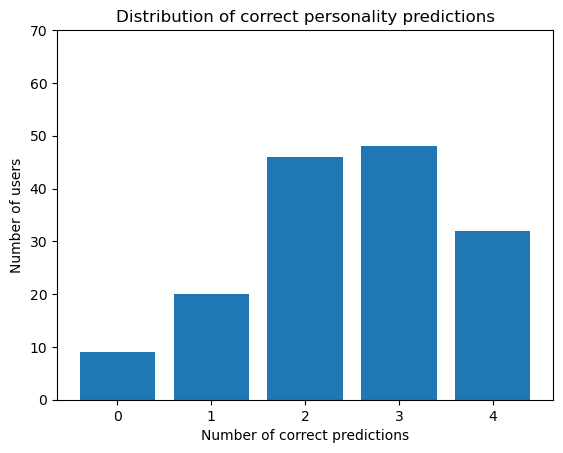

In [50]:
# create bar chart for distribution, show as percentages
import matplotlib.pyplot as plt

plt.bar(distribution.keys(), distribution.values())
plt.xticks([0, 1, 2, 3, 4])
plt.xlabel('Number of correct predictions')
plt.ylabel('Number of users')
plt.ylim(0, 70)
plt.title('Distribution of correct personality predictions')
plt.show()



In [48]:
# percentage of getting 3-4 correct

(distribution[3] + distribution[4]) / sum(distribution.values())

0.5161290322580645